# What you will Learn
NLP is one of the most important areas of data science. This notebook focuses on the detection of `Fake News`. Most people tend to use deep learning approaches based on word embeddings, word sequences and other elaborate methods to detect them. In this notebook you will learn, that you can already achieve extremely good results by focusing on easily extracted features. Even though these methods are far from perfect, they are easy to perform and they allow us to get some valuable insights into the structure of Fake News.

<div class="alert alert-danger" role="alert">
    <h3>This notebook is work in progress. Feel free to <span style="color:red">comment</span> if you have any suggestions   |   motivate me with an <span style="color:red">upvote</span> if you like this project.</h3>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from wordcloud import STOPWORDS
import nltk
import string

# Get an overview of both CSVs and merge them together!
The data is provided in two separated csv files. One file contains real articles, the other file contains fake news. Let's get an idea of both files.

In [ ]:
fake = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
news = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

## Let's take a look at Real News

In [ ]:
news

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


are there any missing values in `News.csv`?

In [ ]:
news.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

not a single column contains missing values!

Which `subjects` are contained in this file?

In [ ]:
news['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

## Let's take a look at Fake News

In [ ]:
fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


are there any missing values in `Fake.csv`?

In [ ]:
fake.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

not a single column contains missing values!

Which `subjects` are contained in this file?

In [ ]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

-> Both CSV files contain the same variables, `title`, `text`, `subject`, and `date`. We have roughly as many real news as fake news. THis might be very supportive for fututre predictions. We don't need to oversample or undersample our dataset, because the dataset is balanced w.r.t. the target. Unfortunately, none of the files contains an explicit column for the target variable `is_fake`. Let's create such a column! Afterwards we can merge them together into one file!

In [ ]:
news['is_fake'] = 0 # contains only news
fake['is_fake'] = 1 # contains only fakes

# merge them into one file
data = pd.concat([news, fake])
data = data.reset_index()
# don't forget to shuffle them. 
# Otherwise all news are on top and all fakes are on the bottom
data = data.sample(frac=1)

For this notebook, I will ignore the `dates` and `subjects`(because they are disjoint). I will probably take a look at them in a later project. Let's drop them for now.

In [ ]:
data.duplicated().sum()

0

Are there any duplicates in the data? If yes, we would have to remove them

In [ ]:
data = data.drop(['date', 'subject'], axis=1)


Before taking a closer look at the data, perform a `train_test_split` to evade **Data Snooping**!

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)
X_train = train.drop('is_fake', axis=1)
y_train = train['is_fake']
X_test = test.drop('is_fake', axis=1)
y_test = test['is_fake']

how are Fake News distributed among the train and the test data?

In [ ]:
y_train.value_counts()

1    18817
0    17101
Name: is_fake, dtype: int64

In [ ]:
y_test.value_counts()

1    4664
0    4316
Name: is_fake, dtype: int64

# Inspect the Training data to get further insights
Therefore we have to split the Training set into News and Fake News

In [ ]:
train_news = X_train.loc[(y_train==0),:]
train_fake = X_train.loc[(y_train==1),:]

## Lexical Diversity of Fake News
Let's define a measure for lexical diversity to find out how many unique vocabs are used in Fake News articles.

Let's define the lexical diversity measure as $\frac{\text{number of unique words in one (target)category}}{\text{number of words in both (target)categories}}$

In [ ]:
# a very simple measure for lexical diversity
def lexical_diversity(data, other_data, feature):
    # ignoare capital letters
    column = data[feature].str.lower() 
    # create one text from the column
    text = ' '.join(column)
    # drop punctuation
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    # create a list of wordsw instead of one huge text
    words_splitted = words.split()
    
    # analogously
    other_column = other_data[feature].str.lower() 
    other_text = ' '.join(other_column)
    other_words = ''.join(char for char in other_text if char not in exclude)
    other_words_splitted = other_words.split()
    # lexical diversity measure
    return len(set(words_splitted)) / (len(words_splitted) + len(other_words_splitted))

print(f'Real News: {lexical_diversity(data=train_news, other_data=train_fake, feature="text")}')
print(f'Fake News: {lexical_diversity(data=train_fake, other_data=train_news, feature="text")}')

Real News: 0.006294777673831783
Fake News: 0.01155576184167068


Interestingly it seems like `Fake News` contain almost two times greater lexical diversity than real news. Their authors seem to have a wide vocabulary.

## Most frequently used words in Titles
is there a difference between the most frequently used words in the titles of Real News and Fake News? This question might already reveal the topics of the Fake News articles.

In [ ]:
stopwords = set(STOPWORDS)

def common_tokens_title(data, feature, name):
    column = data[feature].str.lower() 
    text = ' '.join(column)
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    words_splitted = words.split()
    words_stopped = [word for word in words_splitted if not word in stopwords]
    print(f'{name}:\n{pd.DataFrame(nltk.FreqDist(words_stopped).most_common(10))[0]}')
    
common_tokens_title(train_news, 'title', 'Most common descriptive words in Real News Titles')
print('\n')
common_tokens_title(train_fake, 'title', 'Most common descriptive words in Fake News Titles')

Most common descriptive words in Real News Titles:
0     trump
1        us
2      says
3     house
4     north
5       new
6     white
7     korea
8    russia
9    senate
Name: 0, dtype: object


Most common descriptive words in Fake News Titles:
0        video
1        trump
2        watch
3        obama
4      hillary
5      trump’s
6    president
7           us
8      clinton
9     breaking
Name: 0, dtype: object


It seems like most Fake News Articles in our Training data are about US Presidents and candidates for the latter. Besides `trump`, the real news seem to focus on more general political topics.

# Punctutation
Punctuation might provide some information for predictions. 

In [ ]:
import regex as re

# let's begin with a helper function to count punctuation
def count_punctuation(text):
    peri = re.subn(r"\.", '', text)[1]
    comm = re.subn(r"\,", '', text)[1]
    ques = re.subn(r"\?", '', text)[1]
    excl = re.subn(r"\!", '', text)[1]
    return [peri,comm, ques, excl]
    
count_punctuation('...alph!a.beta.gamma...??')

[8, 0, 2, 1]

In [ ]:
# count the usage of puntuations per row in a specified feature (title and text)
# and store the data in a dataframe
def create_punctuation_df(dataset, feature):
    return dataset.apply(lambda row: pd.Series({'peri_' + feature:count_punctuation(row[feature])[0], 
                                                       'comm_' + feature:count_punctuation(row[feature])[1],
                                                      'ques_' + feature:count_punctuation(row[feature])[2],
                                                      'excl_' + feature:count_punctuation(row[feature])[3]}), axis=1)

punctuation_train_title = create_punctuation_df(train, 'title')
punctuation_test_title = create_punctuation_df(test, 'title')
punctuation_train_text = create_punctuation_df(train, 'text')
punctuation_test_text = create_punctuation_df(test, 'text')
punctuation_train_text 

,peri_text,comm_text,ques_text,excl_text
36115,28,19,0,1
44800,6,11,0,3
33108,3,3,0,0
36535,5,1,1,1
15801,27,22,0,0
...,...,...,...,...
16562,24,27,0,0
5116,13,7,0,0
7782,32,29,0,0
33836,0,0,0,0


# Text Length

In [ ]:
# count the text length per row for both features (title and text)
# and store the information in a dataframe
def create_len_df(dataset):
    return dataset.apply(lambda row: pd.Series({'length_title':len(row['title']),
                                               'length_text':len(row['text'])}), axis=1)

len_train = create_len_df(train)
len_test = create_len_df(test)

len_train

,length_title,length_text
36115,85,1476
44800,65,1269
33108,127,591
36535,43,577
15801,60,3354
...,...,...
16562,77,2898
5116,74,1857
7782,63,4422
33836,82,1


## Number of Words in the Title
Let's create a feature which counts the number of words in the Title. In my **Digital Markeeting Courses** I learned, that titles are extremely important when it comes to grabbing Attention. A rule of thumbs tells us that titles should have about 5 words.

In [ ]:
def create_num_words_df(dataset):
    return dataset.apply(lambda row: pd.Series({'num_words_title':len(row['title'].split())}), axis=1)

num_words_train = create_num_words_df(train)
num_words_test = create_num_words_df(test)

num_words_train

,num_words_title
36115,14
44800,12
33108,21
36535,7
15801,9
...,...
16562,12
5116,11
7782,8
33836,11


## Lenght of Title Relative to the Length of the Article + Title
One could assume that some attention grabbing Fake News have a long title and very short texts. Is that true?

In [2]:
def create_title_ratio_df(dataset):
    return dataset.apply(lambda row: pd.Series({'title_ratio':len(row['title'])/(len(row['title']) + len(row['text']))}), axis=1)

title_ratio_train = create_title_ratio_df(train)
title_ratio_test = create_title_ratio_df(test)

title_ratio_train

NameError: ignored

## Concatenate the new Datasets

In [ ]:
X_train_punct_len = pd.concat([punctuation_train_title, 
                               punctuation_train_text, 
                               len_train, 
                               num_words_train, 
                               title_ratio_train], 
                              axis=1)

X_test_punct_len = pd.concat([punctuation_test_title, 
                              punctuation_test_text, 
                              len_test, 
                              num_words_test, 
                              title_ratio_test], 
                             axis=1)

X_train_punct_len

,peri_title,comm_title,ques_title,excl_title,peri_text,comm_text,ques_text,excl_text,length_title,length_text,num_words_title,title_ratio
36115,0,0,0,1,28,19,0,1,85,1476,14,0.054452
44800,0,0,0,0,6,11,0,3,65,1269,12,0.048726
33108,1,0,0,1,3,3,0,0,127,591,21,0.176880
36535,0,0,1,0,5,1,1,1,43,577,7,0.069355
15801,0,0,0,0,27,22,0,0,60,3354,9,0.017575
...,...,...,...,...,...,...,...,...,...,...,...,...
16562,0,1,0,0,24,27,0,0,77,2898,12,0.025882
5116,2,1,0,0,13,7,0,0,74,1857,11,0.038322
7782,0,1,0,0,32,29,0,0,63,4422,8,0.014047
33836,0,0,0,0,0,0,0,0,82,1,11,0.987952


# Investigate the Engineered Features

In [ ]:
X_train_punct_len.describe()

,peri_title,comm_title,ques_title,excl_title,peri_text,comm_text,ques_text,excl_text,length_title,length_text,num_words_title,title_ratio
count,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000
mean,0.269920,0.225374,0.041567,0.081018,20.943928,20.258533,0.676819,0.410324,80.110613,2472.432457,12.449969,0.071556
std,0.694986,0.499536,0.212308,0.299894,18.436810,20.440653,1.820497,1.514863,25.327528,2193.414470,4.098040,0.135138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,1.000000,0.000583
25%,0.000000,0.000000,0.000000,0.000000,10.000000,8.000000,0.000000,0.000000,63.000000,1239.000000,10.000000,0.023314
50%,0.000000,0.000000,0.000000,0.000000,18.000000,17.000000,0.000000,0.000000,73.000000,2186.000000,11.000000,0.034850
75%,0.000000,0.000000,0.000000,0.000000,27.000000,27.000000,1.000000,0.000000,91.000000,3102.000000,14.000000,0.063622
max,6.000000,5.000000,3.000000,4.000000,555.000000,518.000000,94.000000,133.000000,286.000000,51794.000000,42.000000,0.995556


* Many Titles don't contain any form of `punctuation`!

* Some texts contain suspiciously small amounts of characters. At least one of them contains only 1 chars

Let's remove some extreme outliers!

In [ ]:
from scipy import stats
X_train_punct_len_zscore = X_train_punct_len.apply(stats.zscore, axis=0)
mask_outliers = np.logical_not(((X_train_punct_len_zscore>5).any(axis=1)).values + ((X_train_punct_len_zscore<-5).any(axis=1)).values)
X_train_punct_len = X_train_punct_len.loc[mask_outliers,:]
y_train = y_train[X_train_punct_len.index]

How does our data look like now?

In [ ]:
X_train_punct_len.describe()

,peri_title,comm_title,ques_title,excl_title,peri_text,comm_text,ques_text,excl_text,length_title,length_text,num_words_title,title_ratio
count,34225.000000,34225.000000,34225.000000,34225.000000,34225.000000,34225.000000,34225.000000,34225.000000,34225.000000,34225.000000,34225.000000,34225.000000
mean,0.262732,0.214697,0.035121,0.060424,20.380131,19.530723,0.576450,0.326311,79.139606,2399.440760,12.293674,0.057091
std,0.665018,0.461984,0.184087,0.238274,14.490819,15.091181,1.258401,0.891098,24.217369,1606.926843,3.913157,0.072461
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,23.000000,1.000000,0.003235
25%,0.000000,0.000000,0.000000,0.000000,10.000000,9.000000,0.000000,0.000000,63.000000,1295.000000,10.000000,0.023296
50%,0.000000,0.000000,0.000000,0.000000,18.000000,17.000000,0.000000,0.000000,73.000000,2198.000000,11.000000,0.034503
75%,0.000000,0.000000,0.000000,0.000000,27.000000,26.000000,1.000000,0.000000,90.000000,3079.000000,14.000000,0.060679
max,3.000000,2.000000,1.000000,1.000000,111.000000,122.000000,9.000000,7.000000,206.000000,12985.000000,32.000000,0.745562


## How do they interact with each other?

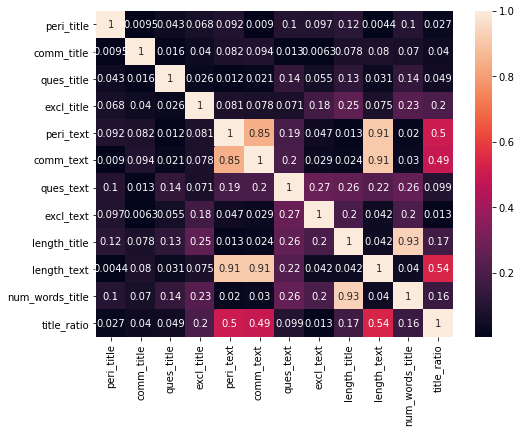

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(np.abs(X_train_punct_len.corr()), annot=True)
plt.savefig('correlation')
plt.show()

* huge correlation between `peri_text` and `length_text`

* huge correlation between `comm_text` and `length_text`

* huge correlation between `comm_text` and `peri_text`

* huge correlation between `peri_test` and `num_words_text`

...and so on

We have to find out how they interact with the target to determine what to do with them.

## How do they Interact with the Target?

In [ ]:
pd.concat([X_train_punct_len, y_train], axis=1).groupby('is_fake').mean()

,peri_title,comm_title,ques_title,excl_title,peri_text,comm_text,ques_text,excl_text,length_title,length_text,num_words_title,title_ratio
is_fake,,,,,,,,,,,,
0,0.441641,0.244312,0.006324,0.000768,20.726257,19.261509,0.093671,0.055257,64.600437,2366.637965,9.941316,0.048417
1,0.087783,0.185737,0.063280,0.118759,20.041667,19.793978,1.048544,0.591366,93.356969,2431.517510,14.593967,0.065573


**Main Findings:**
* Titles of Fake News contain ~4 times less `periods`

* Titles of Fake News contain ~10 times more `question marks`

* Titles of Fake News contain ~130 times more `exclamation marks` **(wow!)**

* Texts of Fake News contain ~10 times more `question marks` 

* Texts of Fake News contain ~10 times more `exclamation marks`

* Titles of Fake News are 50% `longer`. The number of words seems to reflect that fact as well. -> The length of words in the titles of Fake News and real News don't seem to vary a lot.

* $\frac{len(title)}{len(title) + len(text)}$ is ~40% longer in Fake News

* Let's ignore the high correlations we found above. A more elaborate approach would be to eliminate correlating features by dropping them or using dimensionality reduction like PCA

# A Simple Model based on Punctuation and Text Length
Let's use a default RandomForest for our classification!

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
preds = cross_val_predict(rf, X_train_punct_len, y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
acc = accuracy_score(y_true=y_train, y_pred=preds)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.9240665477617613
acc: 0.9241197954711469


These are already pretty nice results on train! What are the most `important features`?

In [ ]:
rf.fit(X_train_punct_len, y_train)
pd.Series(rf.feature_importances_, 
          index=X_train_punct_len.columns).sort_values(ascending=False)

length_title       0.306129
num_words_title    0.172643
ques_text          0.112475
title_ratio        0.093377
length_text        0.087072
excl_text          0.053744
peri_text          0.050766
comm_text          0.050166
peri_title         0.035642
excl_title         0.020598
comm_title         0.011335
ques_title         0.006053
dtype: float64

Interestingly, the length of the title is way more important than e.g. `excl_title`, even though the relation between the target and `excl_title` is way stronger. This is most likely the case because only a few titles contain exclamation marks.

## Finetune the model

In [ ]:
from sklearn.model_selection import GridSearchCV
params= {'n_estimators':[200, 300],
        'criterion':['gini', 'entropy'],
        'max_depth':[5, None],
        'max_features':[2,5]}
gscv = GridSearchCV(rf, params)
gscv.fit(X_train_punct_len, y_train)
gscv.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 2,
 'n_estimators': 300}

In [ ]:
rf_tuned = RandomForestClassifier(criterion='entropy', max_depth=None, max_features=2, n_estimators=200, random_state=42)
preds = cross_val_predict(rf_tuned, X_train_punct_len, y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
acc = accuracy_score(y_true=y_train, y_pred=preds)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.9252473218989639
acc: 0.9253761869978087


In [ ]:
rf_tuned.fit(X_train_punct_len, y_train)
pd.Series(rf_tuned.feature_importances_, 
          index=X_train_punct_len.columns).sort_values(ascending=False)

length_title       0.250700
num_words_title    0.180754
title_ratio        0.108480
ques_text          0.100785
length_text        0.098615
peri_text          0.062601
comm_text          0.062418
excl_text          0.050390
peri_title         0.038489
excl_title         0.026186
comm_title         0.013181
ques_title         0.007400
dtype: float64

## Final Prediction on Test

In [ ]:
preds_test = rf_tuned.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.9328866313628011
acc: 0.9308463251670379


`f1-score` of about 93%! Our model is already very powerful, even though it solely focuses on punctuation and text length. Moreover, it performs even better than on train!

# How well can we predict on subsets of the Features?

In [ ]:
forest = RandomForestClassifier(random_state=42)

best_column = 'all'
best_score = 0
for column in X_train_punct_len.columns:
    forest.fit(X_train_punct_len[column].values.reshape((-1,1)), y_train)
    preds = cross_val_predict(forest, X_train_punct_len[column].values.reshape((-1,1)), y_train, cv=5)
    f1 = f1_score(y_true=y_train, y_pred=preds)
    
    if(f1>best_score):
        best_score = f1
        best_column = column

print(f'A default RandomForest already obtains an f1-score of {f1} on validation data when trained solely on the column {column}')

A default RandomForest already obtains an f1-score of 0.6732986660637575 on validation data when trained solely on the column title_ratio


In [ ]:
forest = RandomForestClassifier(random_state=42)
punctuation = ['peri_title', 'comm_title', 'ques_title', 'excl_title', 'peri_text', 'comm_text', 'ques_text', 'excl_text']
lenght = ['length_title', 'length_text','num_words_title', 'title_ratio']


forest.fit(X_train_punct_len[punctuation], y_train)
preds = cross_val_predict(forest, X_train_punct_len[punctuation], y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
print(f'A default RandomForest already obtains an f1-score of {f1} when trained solely on punctuation-based Features')
print('The Feature Inportances in that approach are:')
print(pd.Series(forest.feature_importances_, 
          index=punctuation).sort_values(ascending=False))

forest.fit(X_train_punct_len[lenght], y_train)
preds = cross_val_predict(forest, X_train_punct_len[lenght], y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
print(f'A default RandomForest already obtains an f1-score of {f1} when trained solely on length-based Features')
print('The Feature Importances in that approach are:')
print(pd.Series(forest.feature_importances_, 
          index=lenght).sort_values(ascending=False))

A default RandomForest already obtains an f1-score of 0.7751509817607962 when trained solely on punctuation-based Features
The Feature Inportances in that approach are:
ques_text     0.273933
comm_text     0.208727
peri_text     0.193682
excl_text     0.134225
peri_title    0.080427
excl_title    0.070758
ques_title    0.024456
comm_title    0.013792
dtype: float64
A default RandomForest already obtains an f1-score of 0.8616304284123543 when trained solely on length-based Features
The Feature Importances in that approach are:
length_title       0.414075
title_ratio        0.210917
length_text        0.198954
num_words_title    0.176054
dtype: float64


As we saw, even some basic feature engineering might reveal powerful features for our machine learning models. I am pretty sure that adding `Word Embeddings` will improve the performance by a lot.

Thank you for reading this notebook!